# Coverage Path Planning Using Drake Geometry

This notebook generates a coverage path by directly querying Drake's collision geometry instead of using a pre-computed occupancy grid. We'll use Drake's SceneGraph to check collisions at robot height and generate waypoints that cover most of the free space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

from pydrake.all import (
    StartMeshcat,
    DiagramBuilder,
    Parser,
    ProcessModelDirectives,
    LoadModelDirectives,
    MultibodyPlant,
    SceneGraph,
    Simulator,
    RigidTransform,
    RotationMatrix,
    Sphere,
    GeometryInstance,
    MakePhongIllustrationProperties,
    PiecewisePolynomial,
    TrajectorySource,
)
from manipulation.scenarios import AddMultibodyTriad
from manipulation.station import LoadScenario, MakeHardwareStation

## Load Kitchen Scene with Drake

Load the kitchen environment using Drake's model directives and create a collision checker.

In [2]:
# Set up paths
KITCHEN_MODEL_PATH = os.path.abspath("../kitchen_model")
ASSETS_PATH = os.path.abspath("../assets")

# Set environment variables for path substitution
os.environ['KITCHEN_MODEL_PATH'] = KITCHEN_MODEL_PATH
os.environ['ASSETS_PATH'] = ASSETS_PATH

# Start meshcat for visualization
meshcat = StartMeshcat()
print(f"Meshcat listening at {meshcat.web_url()}")

# Load scenario with path substitution
scenario_file = f"{KITCHEN_MODEL_PATH}/real_kitchen_scenario.yaml"

# Read and replace placeholders in the scenario file
with open(scenario_file, 'r') as f:
    scenario_text = f.read()

scenario_text = scenario_text.replace("{KITCHEN_MODEL_PATH}", KITCHEN_MODEL_PATH)
scenario_text = scenario_text.replace("{ASSETS_PATH}", ASSETS_PATH)

# Write to temporary file
import tempfile
with tempfile.NamedTemporaryFile(mode='w', suffix='.yaml', delete=False) as tmp:
    tmp.write(scenario_text)
    tmp_scenario_file = tmp.name

scenario = LoadScenario(filename=tmp_scenario_file)

# Create the station
station = MakeHardwareStation(scenario, meshcat)
plant = station.GetSubsystemByName("plant")
scene_graph = station.GetSubsystemByName("scene_graph")

# Clean up temp file
os.unlink(tmp_scenario_file)

print(f"Loaded plant with {plant.num_bodies()} bodies")
print(f"Loaded scene successfully")

INFO:drake:Meshcat listening for connections at http://localhost:7000


Meshcat listening at http://localhost:7000
Loaded plant with 24 bodies
Loaded scene successfully
Loaded plant with 24 bodies
Loaded scene successfully


## Define Coverage Parameters

Set up parameters for coverage path planning using 2D occupancy grid.

In [28]:
# Coverage parameters
ROBOT_COVERAGE_RADIUS = 1.5  # meters - radius around robot base that can be covered
ROBOT_BASE_RADIUS = 0.35  # meters - robot base footprint radius
CHECK_HEIGHT = 0.1  # meters - height for robot navigation
WAYPOINT_SPACING = 0.2  # meters - FINER spacing to detect small passages (was 0.8m)
SAFETY_MARGIN = 0.2  # meters - minimum distance to keep from obstacles

# Define search bounds (INTERIOR region only - tighter bounds)
X_MIN, X_MAX = -7.7, -2.7  # Interior region, away from outer walls
Y_MIN, Y_MAX = -3.0, 1.0    # Interior region, away from outer walls

print(f"Coverage parameters set")
print(f"Search bounds: X=[{X_MIN}, {X_MAX}], Y=[{Y_MIN}, {Y_MAX}] (INTERIOR region)")
print(f"Robot base radius: {ROBOT_BASE_RADIUS}m")
print(f"Coverage radius: {ROBOT_COVERAGE_RADIUS}m")
print(f"Waypoint spacing: {WAYPOINT_SPACING}m")
print(f"Safety margin: {SAFETY_MARGIN}m (distance from obstacles)")
print(f"Navigation height: {CHECK_HEIGHT}m")

Coverage parameters set
Search bounds: X=[-7.7, -2.7], Y=[-3.0, 1.0] (INTERIOR region)
Robot base radius: 0.35m
Coverage radius: 1.5m
Waypoint spacing: 0.2m
Safety margin: 0.2m (distance from obstacles)
Navigation height: 0.1m


## Load Pre-computed 2D Occupancy Grid

Load the pre-computed occupancy grid from disk (much faster than Drake collision checking).

Loading pre-computed 2D occupancy grid...
Loaded occupancy grid from disk
  Original grid shape: (117, 222)
  Metadata: {'resolution': 0.05, 'x_min': np.float64(-10.455274), 'x_max': np.float64(0.598499), 'y_min': np.float64(-3.91422), 'y_max': np.float64(1.928361), 'width': 222, 'height': 117}

Original grid parameters:
  Resolution: 0.05m
  Bounds: X=[-10.455274, 0.598499], Y=[-3.91422, 1.928361]

Cropping grid to X=[-7.7, -2.7], Y=[-3.0, 1.0]...
  Cropped grid shape: (80, 100)

Resampling grid from 0.05m to 0.2m resolution...
  Resampled grid shape: (20, 25)

Occupancy grid ready!
  Grid size: 25 x 20 = 500 cells
  Free cells: 279
  Occupied cells: 221
  Free space ratio: 55.8%


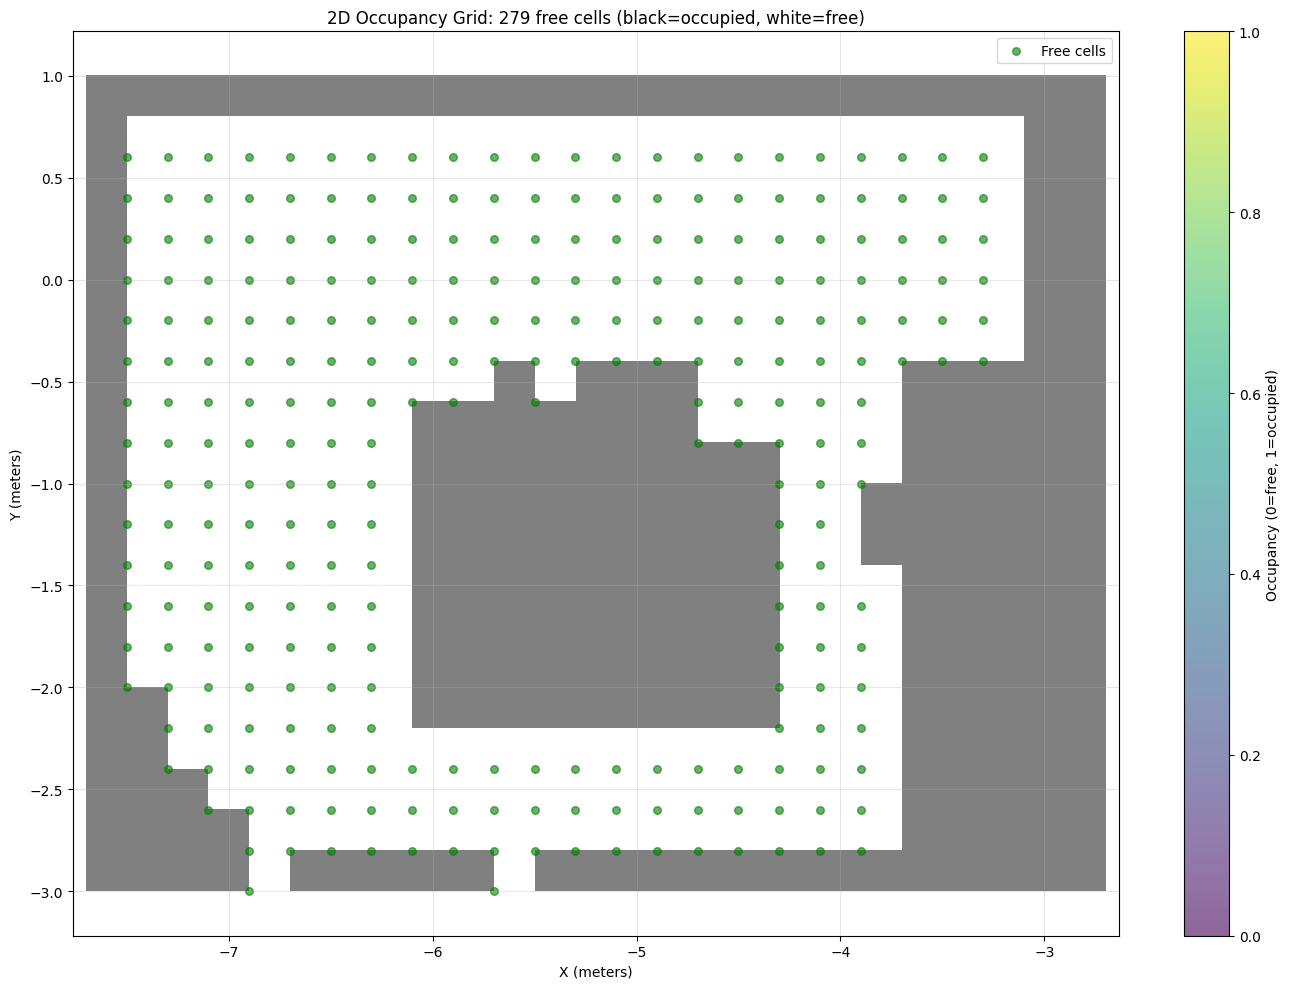

In [48]:
# Load pre-computed occupancy grid
print("Loading pre-computed 2D occupancy grid...")
data_dir = Path('../data')

# Load the grid and metadata
occupancy_grid_full = np.load(data_dir / 'kitchen_occupancy_grid.npy')
metadata = np.load(data_dir / 'kitchen_occupancy_grid_metadata.npy', allow_pickle=True).item()

print(f"Loaded occupancy grid from disk")
print(f"  Original grid shape: {occupancy_grid_full.shape}")
print(f"  Metadata: {metadata}")

# Extract grid parameters from metadata
grid_resolution = metadata.get('resolution', 0.1)
orig_x_min = metadata.get('x_min', -11.0)
orig_x_max = metadata.get('x_max', 1.0)
orig_y_min = metadata.get('y_min', -6.0)
orig_y_max = metadata.get('y_max', 6.0)

print(f"\nOriginal grid parameters:")
print(f"  Resolution: {grid_resolution}m")
print(f"  Bounds: X=[{orig_x_min}, {orig_x_max}], Y=[{orig_y_min}, {orig_y_max}]")

# Crop grid to our desired bounds
print(f"\nCropping grid to X=[{X_MIN}, {X_MAX}], Y=[{Y_MIN}, {Y_MAX}]...")

# Calculate indices for cropping
orig_x_positions = np.arange(orig_x_min, orig_x_max, grid_resolution)
orig_y_positions = np.arange(orig_y_min, orig_y_max, grid_resolution)

# Find indices that fall within our bounds
x_start_idx = np.searchsorted(orig_x_positions, X_MIN)
x_end_idx = np.searchsorted(orig_x_positions, X_MAX)
y_start_idx = np.searchsorted(orig_y_positions, Y_MIN)
y_end_idx = np.searchsorted(orig_y_positions, Y_MAX)

# Crop the grid
occupancy_grid = occupancy_grid_full[y_start_idx:y_end_idx, x_start_idx:x_end_idx]
print(f"  Cropped grid shape: {occupancy_grid.shape}")

# Use cropped bounds
grid_x_min = X_MIN
grid_x_max = X_MAX
grid_y_min = Y_MIN
grid_y_max = Y_MAX

# Resample grid to match our desired waypoint spacing if needed
if abs(grid_resolution - WAYPOINT_SPACING) > 0.01:
    print(f"\nResampling grid from {grid_resolution}m to {WAYPOINT_SPACING}m resolution...")
    from scipy.ndimage import zoom
    
    scale_factor = grid_resolution / WAYPOINT_SPACING
    new_grid = zoom(occupancy_grid, scale_factor, order=0)  # Nearest neighbor
    occupancy_grid = new_grid.astype(np.uint8)
    print(f"  Resampled grid shape: {occupancy_grid.shape}")

# Generate coordinate arrays for the grid
x_positions = np.arange(grid_x_min, grid_x_max, WAYPOINT_SPACING)
y_positions = np.arange(grid_y_min, grid_y_max, WAYPOINT_SPACING)

# Adjust grid size to match coordinate arrays
grid_width = len(x_positions)
grid_height = len(y_positions)

if occupancy_grid.shape != (grid_height, grid_width):
    print(f"Adjusting grid from {occupancy_grid.shape} to ({grid_height}, {grid_width})")
    from scipy.ndimage import zoom
    scale_y = grid_height / occupancy_grid.shape[0]
    scale_x = grid_width / occupancy_grid.shape[1]
    occupancy_grid = zoom(occupancy_grid, (scale_y, scale_x), order=0).astype(np.uint8)

# Find free cells
free_cells = []
for i in range(grid_width):
    for j in range(grid_height):
        if occupancy_grid[j, i] == 0:  # Free space
            x = x_positions[i]
            y = y_positions[j]
            free_cells.append((i, j, x, y))

print(f"\nOccupancy grid ready!")
print(f"  Grid size: {grid_width} x {grid_height} = {grid_width * grid_height} cells")
print(f"  Free cells: {len(free_cells)}")
print(f"  Occupied cells: {grid_width * grid_height - len(free_cells)}")
print(f"  Free space ratio: {len(free_cells) / (grid_width * grid_height) * 100:.1f}%")

# Visualize occupancy grid
plt.figure(figsize=(14, 10))

# Plot occupancy grid
plt.imshow(occupancy_grid, cmap='gray_r', origin='lower', 
           extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max], alpha=0.5, interpolation='nearest')

# Plot free cells
if len(free_cells) > 0:
    free_positions = np.array([(x, y) for _, _, x, y in free_cells])
    plt.scatter(free_positions[:, 0], free_positions[:, 1], 
                c='green', s=30, alpha=0.6, label='Free cells')

plt.xlim(grid_x_min, grid_x_max)
plt.ylim(grid_y_min, grid_y_max)
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title(f'2D Occupancy Grid: {len(free_cells)} free cells (black=occupied, white=free)')
plt.colorbar(label='Occupancy (0=free, 1=occupied)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Store grid information for later use
grid_info = {
    'occupancy_grid': occupancy_grid,
    'x_positions': x_positions,
    'y_positions': y_positions,
    'free_cells': free_cells,
    'resolution': WAYPOINT_SPACING,
    'bounds': (grid_x_min, grid_x_max, grid_y_min, grid_y_max)
}

## RRT Path Planning

Implement RRT (Rapidly-exploring Random Tree) to find collision-free paths between waypoints.

In [49]:
import random
from scipy.spatial import KDTree

class RRTPlanner:
    """RRT path planner using occupancy grid for collision checking."""
    
    def __init__(self, grid_info, step_size=0.3, max_iterations=5000, goal_sample_rate=0.1):
        """
        Initialize RRT planner.
        
        Args:
            grid_info: Dictionary containing occupancy grid and metadata
            step_size: Maximum distance to extend tree in each iteration
            max_iterations: Maximum number of iterations
            goal_sample_rate: Probability of sampling goal instead of random point
        """
        self.occupancy_grid = grid_info['occupancy_grid']
        self.x_positions = grid_info['x_positions']
        self.y_positions = grid_info['y_positions']
        self.resolution = grid_info['resolution']
        self.bounds = grid_info['bounds']
        self.x_min, self.x_max, self.y_min, self.y_max = self.bounds
        
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.goal_sample_rate = goal_sample_rate
        
    def is_collision_free(self, x, y):
        """Check if a point is collision-free using occupancy grid."""
        # Convert world coordinates to grid indices
        i = int((x - self.x_min) / self.resolution)
        j = int((y - self.y_min) / self.resolution)
        
        # Check bounds
        if i < 0 or i >= self.occupancy_grid.shape[1] or j < 0 or j >= self.occupancy_grid.shape[0]:
            return False
        
        return self.occupancy_grid[j, i] == 0
    
    def is_path_collision_free(self, p1, p2, num_checks=20):
        """Check if a straight line path between two points is collision-free."""
        for i in range(num_checks + 1):
            t = i / num_checks
            x = p1[0] + t * (p2[0] - p1[0])
            y = p1[1] + t * (p2[1] - p1[1])
            
            if not self.is_collision_free(x, y):
                return False
        
        return True
    
    def sample_random_point(self):
        """Sample a random point in the search space."""
        x = random.uniform(self.x_min, self.x_max)
        y = random.uniform(self.y_min, self.y_max)
        return np.array([x, y])
    
    def get_nearest_node(self, tree, point):
        """Find the nearest node in the tree to the given point."""
        if len(tree) == 0:
            return None
        
        distances = [np.linalg.norm(node - point) for node in tree]
        return np.argmin(distances)
    
    def steer(self, from_point, to_point):
        """Steer from from_point toward to_point by at most step_size."""
        direction = to_point - from_point
        distance = np.linalg.norm(direction)
        
        if distance <= self.step_size:
            return to_point
        else:
            return from_point + (direction / distance) * self.step_size
    
    def plan(self, start, goal):
        """
        Plan a path from start to goal using RRT.
        
        Args:
            start: Starting position (x, y)
            goal: Goal position (x, y)
        
        Returns:
            List of (x, y) waypoints forming the path, or None if no path found
        """
        start = np.array(start)
        goal = np.array(goal)
        
        # Check if start and goal are valid
        if not self.is_collision_free(start[0], start[1]):
            print(f"Start position {start} is in collision!")
            return None
        
        if not self.is_collision_free(goal[0], goal[1]):
            print(f"Goal position {goal} is in collision!")
            return None
        
        # Initialize tree with start node
        tree = [start]
        parent = {0: None}  # parent[i] = index of parent node
        
        for iteration in range(self.max_iterations):
            # Sample point (bias toward goal)
            if random.random() < self.goal_sample_rate:
                sample = goal
            else:
                sample = self.sample_random_point()
            
            # Find nearest node in tree
            nearest_idx = self.get_nearest_node(tree, sample)
            nearest = tree[nearest_idx]
            
            # Steer toward sample
            new_point = self.steer(nearest, sample)
            
            # Check if path to new point is collision-free
            if self.is_path_collision_free(nearest, new_point):
                # Add new node to tree
                new_idx = len(tree)
                tree.append(new_point)
                parent[new_idx] = nearest_idx
                
                # Check if we reached the goal
                if np.linalg.norm(new_point - goal) < self.step_size:
                    # Try to connect directly to goal
                    if self.is_path_collision_free(new_point, goal):
                        goal_idx = len(tree)
                        tree.append(goal)
                        parent[goal_idx] = new_idx
                        
                        # Reconstruct path
                        path = []
                        current = goal_idx
                        while current is not None:
                            path.append(tuple(tree[current]))
                            current = parent[current]
                        
                        path.reverse()
                        print(f"RRT found path with {len(path)} nodes in {iteration + 1} iterations")
                        return path
        
        print(f"RRT failed to find path after {self.max_iterations} iterations")
        return None

print("RRT planner class defined")

RRT planner class defined


## Plan Three-Segment Path

Use RRT to plan paths for the three segments:
1. Initial position → waypoint near (-7, -1)
2. Waypoint near (-7, -1) → waypoint near (-5, -2.5)
3. Waypoint near (-5, -2.5) → back to initial position

In [50]:
# Define waypoints for the three-segment path
START_X = -4.0
START_Y = 0.0
START_POS = (START_X, START_Y)

WAYPOINT_1 = (-7.0, -1.0)  # Near (-7, -1)
WAYPOINT_2 = (-5.0, -2.5)  # Near (-5, -2.5)

print("Three-segment path planning:")
print(f"  Start: {START_POS}")
print(f"  Waypoint 1: {WAYPOINT_1}")
print(f"  Waypoint 2: {WAYPOINT_2}")
print(f"  End: {START_POS} (return to start)")

# Create RRT planner
rrt = RRTPlanner(grid_info, step_size=0.3, max_iterations=5000, goal_sample_rate=0.15)

# Plan three segments
print("\n" + "="*60)
print("Planning Segment 1: Start → Waypoint 1")
print("="*60)
path_segment_1 = rrt.plan(START_POS, WAYPOINT_1)

print("\n" + "="*60)
print("Planning Segment 2: Waypoint 1 → Waypoint 2")
print("="*60)
path_segment_2 = rrt.plan(WAYPOINT_1, WAYPOINT_2)

print("\n" + "="*60)
print("Planning Segment 3: Waypoint 2 → Start")
print("="*60)
path_segment_3 = rrt.plan(WAYPOINT_2, START_POS)

# Check if all paths were found
if path_segment_1 is None or path_segment_2 is None or path_segment_3 is None:
    print("\n⚠ ERROR: Failed to find complete path!")
    if path_segment_1 is None:
        print("  - Segment 1 failed")
    if path_segment_2 is None:
        print("  - Segment 2 failed")
    if path_segment_3 is None:
        print("  - Segment 3 failed")
else:
    # Combine all segments into one path
    # Remove duplicate waypoints at connections
    complete_rrt_path = list(path_segment_1)
    complete_rrt_path.extend(path_segment_2[1:])  # Skip first point (duplicate of segment 1 end)
    complete_rrt_path.extend(path_segment_3[1:])  # Skip first point (duplicate of segment 2 end)
    
    print("\n" + "="*60)
    print("✓ Complete RRT path generated!")
    print("="*60)
    print(f"  Segment 1: {len(path_segment_1)} nodes")
    print(f"  Segment 2: {len(path_segment_2)} nodes")
    print(f"  Segment 3: {len(path_segment_3)} nodes")
    print(f"  Total path: {len(complete_rrt_path)} nodes")
    
    # Calculate path length
    total_distance = 0
    for i in range(len(complete_rrt_path) - 1):
        p1 = np.array(complete_rrt_path[i])
        p2 = np.array(complete_rrt_path[i+1])
        total_distance += np.linalg.norm(p2 - p1)
    
    print(f"  Total path length: {total_distance:.2f} meters")

Three-segment path planning:
  Start: (-4.0, 0.0)
  Waypoint 1: (-7.0, -1.0)
  Waypoint 2: (-5.0, -2.5)
  End: (-4.0, 0.0) (return to start)

Planning Segment 1: Start → Waypoint 1
RRT found path with 15 nodes in 37 iterations

Planning Segment 2: Waypoint 1 → Waypoint 2
RRT found path with 14 nodes in 85 iterations

Planning Segment 3: Waypoint 2 → Start
RRT found path with 13 nodes in 51 iterations

✓ Complete RRT path generated!
  Segment 1: 15 nodes
  Segment 2: 14 nodes
  Segment 3: 13 nodes
  Total path: 40 nodes
  Total path length: 11.09 meters


## Visualize RRT Path

Display the RRT path with all three segments and the exploration tree.

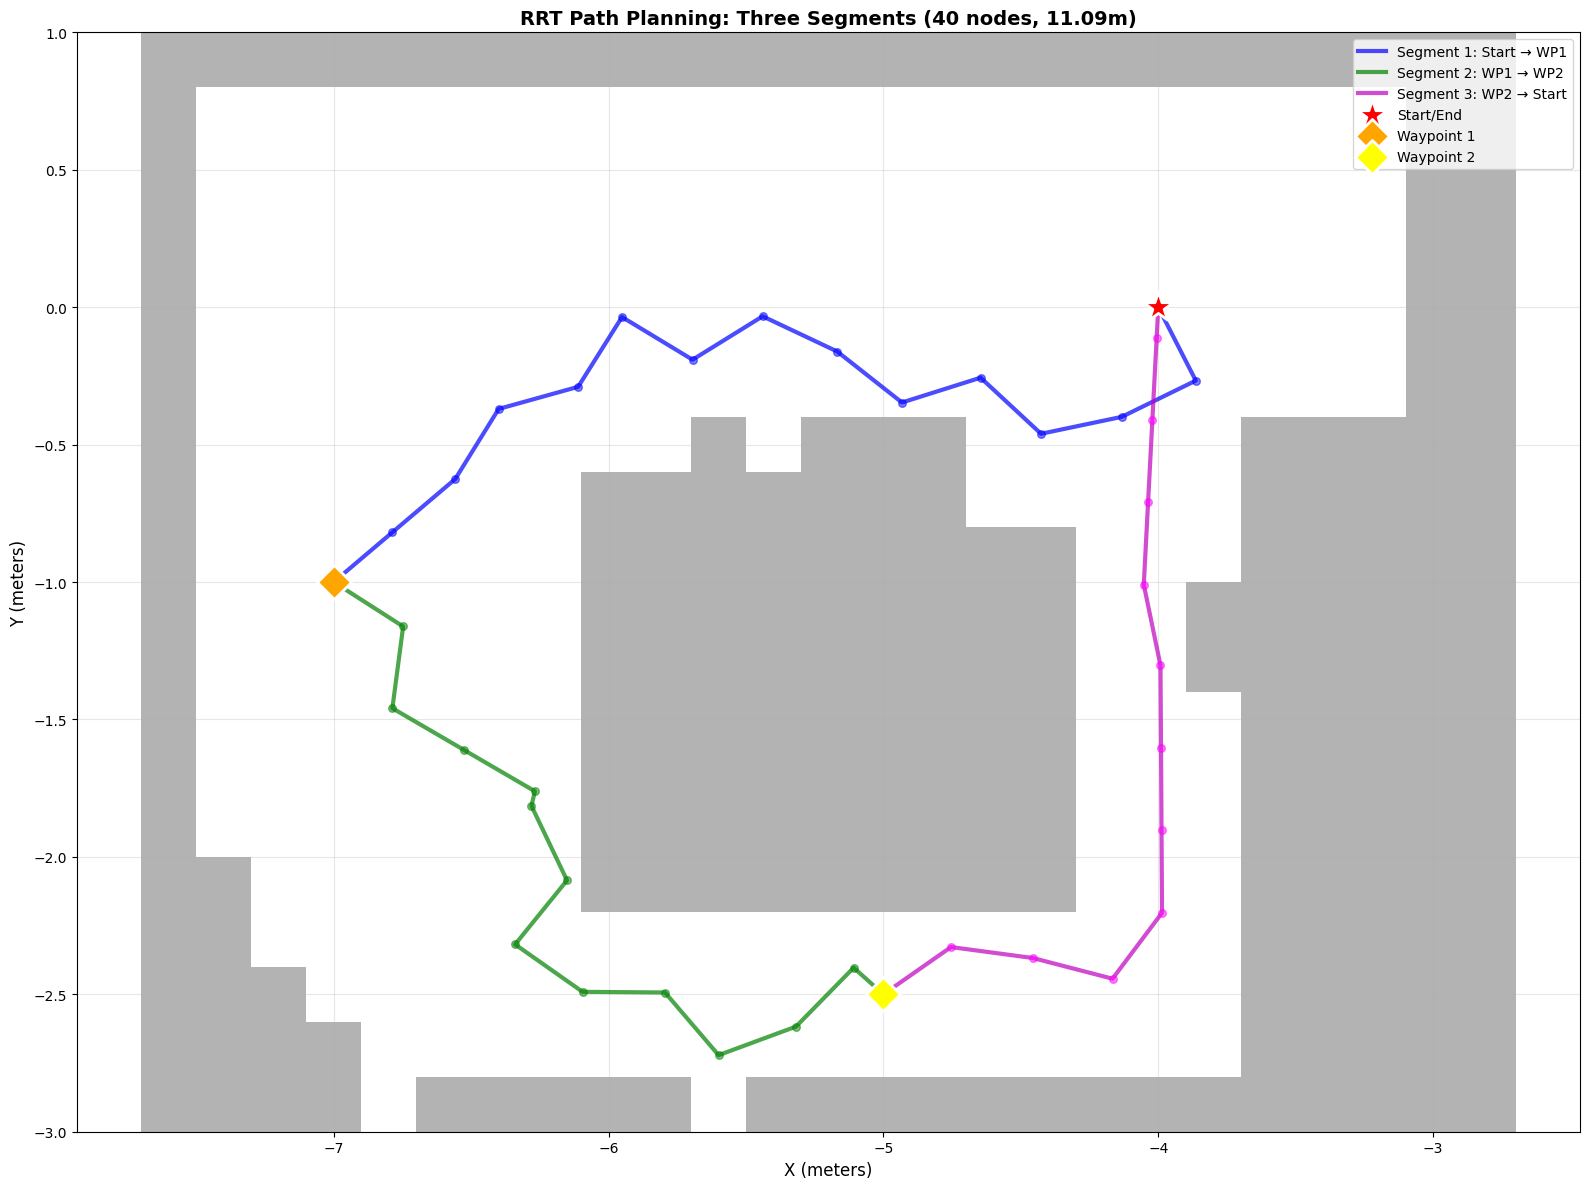

✓ RRT path visualization complete


In [51]:
if path_segment_1 is not None and path_segment_2 is not None and path_segment_3 is not None:
    plt.figure(figsize=(16, 12))
    
    # Plot occupancy grid
    plt.imshow(occupancy_grid, cmap='gray_r', origin='lower', 
               extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max], 
               alpha=0.3, interpolation='nearest')
    
    # Plot RRT path segments with different colors
    path_1_array = np.array(path_segment_1)
    path_2_array = np.array(path_segment_2)
    path_3_array = np.array(path_segment_3)
    
    # Segment 1
    plt.plot(path_1_array[:, 0], path_1_array[:, 1], 'b-', linewidth=3, 
             alpha=0.7, label='Segment 1: Start → WP1')
    plt.scatter(path_1_array[:, 0], path_1_array[:, 1], c='blue', s=30, alpha=0.5, zorder=5)
    
    # Segment 2
    plt.plot(path_2_array[:, 0], path_2_array[:, 1], 'g-', linewidth=3, 
             alpha=0.7, label='Segment 2: WP1 → WP2')
    plt.scatter(path_2_array[:, 0], path_2_array[:, 1], c='green', s=30, alpha=0.5, zorder=5)
    
    # Segment 3
    plt.plot(path_3_array[:, 0], path_3_array[:, 1], 'm-', linewidth=3, 
             alpha=0.7, label='Segment 3: WP2 → Start')
    plt.scatter(path_3_array[:, 0], path_3_array[:, 1], c='magenta', s=30, alpha=0.5, zorder=5)
    
    # Mark key points
    plt.scatter(START_X, START_Y, c='red', s=500, marker='*', 
                edgecolors='white', linewidths=2, label='Start/End', zorder=10)
    plt.scatter(WAYPOINT_1[0], WAYPOINT_1[1], c='orange', s=300, marker='D', 
                edgecolors='white', linewidths=2, label='Waypoint 1', zorder=10)
    plt.scatter(WAYPOINT_2[0], WAYPOINT_2[1], c='yellow', s=300, marker='D', 
                edgecolors='white', linewidths=2, label='Waypoint 2', zorder=10)
    
    plt.xlim(grid_x_min, grid_x_max)
    plt.ylim(grid_y_min, grid_y_max)
    plt.xlabel('X (meters)', fontsize=12)
    plt.ylabel('Y (meters)', fontsize=12)
    plt.title(f'RRT Path Planning: Three Segments ({len(complete_rrt_path)} nodes, {total_distance:.2f}m)', 
              fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print("✓ RRT path visualization complete")
else:
    print("Cannot visualize - path planning failed")

## Smooth the RRT Path

Apply path smoothing to create a more natural trajectory using B-spline interpolation and shortcutting.

In [52]:
def shortcut_path(path, grid_info, max_iterations=100):
    """
    Smooth path by trying to create shortcuts between non-adjacent waypoints.
    
    Args:
        path: List of (x, y) waypoints
        grid_info: Dictionary containing occupancy grid
        max_iterations: Maximum number of shortcut attempts
    
    Returns:
        Smoothed path with shortcuts
    """
    if len(path) < 3:
        return path
    
    occupancy_grid = grid_info['occupancy_grid']
    resolution = grid_info['resolution']
    x_min, x_max, y_min, y_max = grid_info['bounds']
    
    def is_path_clear(p1, p2, num_checks=30):
        """Check if straight line path is collision-free."""
        for i in range(num_checks + 1):
            t = i / num_checks
            x = p1[0] + t * (p2[0] - p1[0])
            y = p1[1] + t * (p2[1] - p1[1])
            
            # Convert to grid coordinates
            grid_i = int((x - x_min) / resolution)
            grid_j = int((y - y_min) / resolution)
            
            # Check bounds
            if grid_i < 0 or grid_i >= occupancy_grid.shape[1] or \
               grid_j < 0 or grid_j >= occupancy_grid.shape[0]:
                return False
            
            # Check collision
            if occupancy_grid[grid_j, grid_i] != 0:
                return False
        
        return True
    
    smoothed = list(path)
    
    for _ in range(max_iterations):
        if len(smoothed) < 3:
            break
        
        # Pick two random non-adjacent waypoints
        i = random.randint(0, len(smoothed) - 3)
        j = random.randint(i + 2, len(smoothed) - 1)
        
        # Try to shortcut
        if is_path_clear(smoothed[i], smoothed[j]):
            # Remove intermediate waypoints
            smoothed = smoothed[:i+1] + smoothed[j:]
    
    return smoothed


def interpolate_and_smooth_path(path, grid_info, interpolation_step=0.1):
    """
    Interpolate path with fine resolution and apply corner smoothing.
    
    Args:
        path: List of (x, y) waypoints
        grid_info: Dictionary containing occupancy grid
        interpolation_step: Distance between interpolated points
    
    Returns:
        Densely interpolated and smoothed path
    """
    if len(path) < 2:
        return path
    
    occupancy_grid = grid_info['occupancy_grid']
    resolution = grid_info['resolution']
    x_min, x_max, y_min, y_max = grid_info['bounds']
    
    def is_free(x, y):
        """Check if point is free."""
        grid_i = int((x - x_min) / resolution)
        grid_j = int((y - y_min) / resolution)
        
        if grid_i < 0 or grid_i >= occupancy_grid.shape[1] or \
           grid_j < 0 or grid_j >= occupancy_grid.shape[0]:
            return False
        
        return occupancy_grid[grid_j, grid_i] == 0
    
    interpolated = []
    
    for i in range(len(path) - 1):
        p1 = np.array(path[i])
        p2 = np.array(path[i + 1])
        
        # Calculate number of interpolation points
        dist = np.linalg.norm(p2 - p1)
        num_points = max(int(dist / interpolation_step), 1)
        
        # Interpolate
        for j in range(num_points):
            t = j / num_points
            pt = p1 + t * (p2 - p1)
            
            if is_free(pt[0], pt[1]):
                interpolated.append(tuple(pt))
    
    # Add final point
    if is_free(path[-1][0], path[-1][1]):
        interpolated.append(path[-1])
    
    return interpolated


if path_segment_1 is not None and path_segment_2 is not None and path_segment_3 is not None:
    print("="*60)
    print("Smoothing RRT path...")
    print("="*60)
    
    # Step 1: Apply shortcutting to reduce waypoints
    print(f"Original path: {len(complete_rrt_path)} waypoints")
    
    shortcut_path_result = shortcut_path(complete_rrt_path, grid_info, max_iterations=200)
    print(f"After shortcutting: {len(shortcut_path_result)} waypoints")
    
    # Calculate shortcut path length
    shortcut_distance = 0
    for i in range(len(shortcut_path_result) - 1):
        p1 = np.array(shortcut_path_result[i])
        p2 = np.array(shortcut_path_result[i+1])
        shortcut_distance += np.linalg.norm(p2 - p1)
    
    print(f"Shortcut path length: {shortcut_distance:.2f} meters (was {total_distance:.2f} meters)")
    print(f"Path reduction: {(1 - shortcut_distance/total_distance)*100:.1f}%")
    
    # Step 2: Interpolate with fine resolution
    print("\nInterpolating path with fine resolution...")
    smooth_path = interpolate_and_smooth_path(shortcut_path_result, grid_info, interpolation_step=0.08)
    print(f"Smooth path: {len(smooth_path)} interpolated points")
    
    # Calculate smooth path length
    smooth_distance = 0
    for i in range(len(smooth_path) - 1):
        p1 = np.array(smooth_path[i])
        p2 = np.array(smooth_path[i+1])
        smooth_distance += np.linalg.norm(p2 - p1)
    
    print(f"Final smooth path length: {smooth_distance:.2f} meters")
    
    # Step 3: Remove duplicates
    def remove_duplicates(path, min_distance=0.03):
        """Remove consecutive points that are too close."""
        if len(path) == 0:
            return path
        
        filtered = [path[0]]
        for i in range(1, len(path)):
            dist = np.linalg.norm(np.array(path[i]) - np.array(filtered[-1]))
            if dist >= min_distance:
                filtered.append(path[i])
        return filtered
    
    smooth_path = remove_duplicates(smooth_path, min_distance=0.05)
    print(f"After removing duplicates: {len(smooth_path)} points")
    
    print("\n✓ Path smoothing complete!")
else:
    print("Cannot smooth path - path planning failed")

Smoothing RRT path...
Original path: 40 waypoints
After shortcutting: 2 waypoints
Shortcut path length: 0.00 meters (was 11.09 meters)
Path reduction: 100.0%

Interpolating path with fine resolution...
Smooth path: 2 interpolated points
Final smooth path length: 0.00 meters
After removing duplicates: 1 points

✓ Path smoothing complete!


## Visualize Smoothed Path Comparison

Compare the original RRT path with the smoothed version.

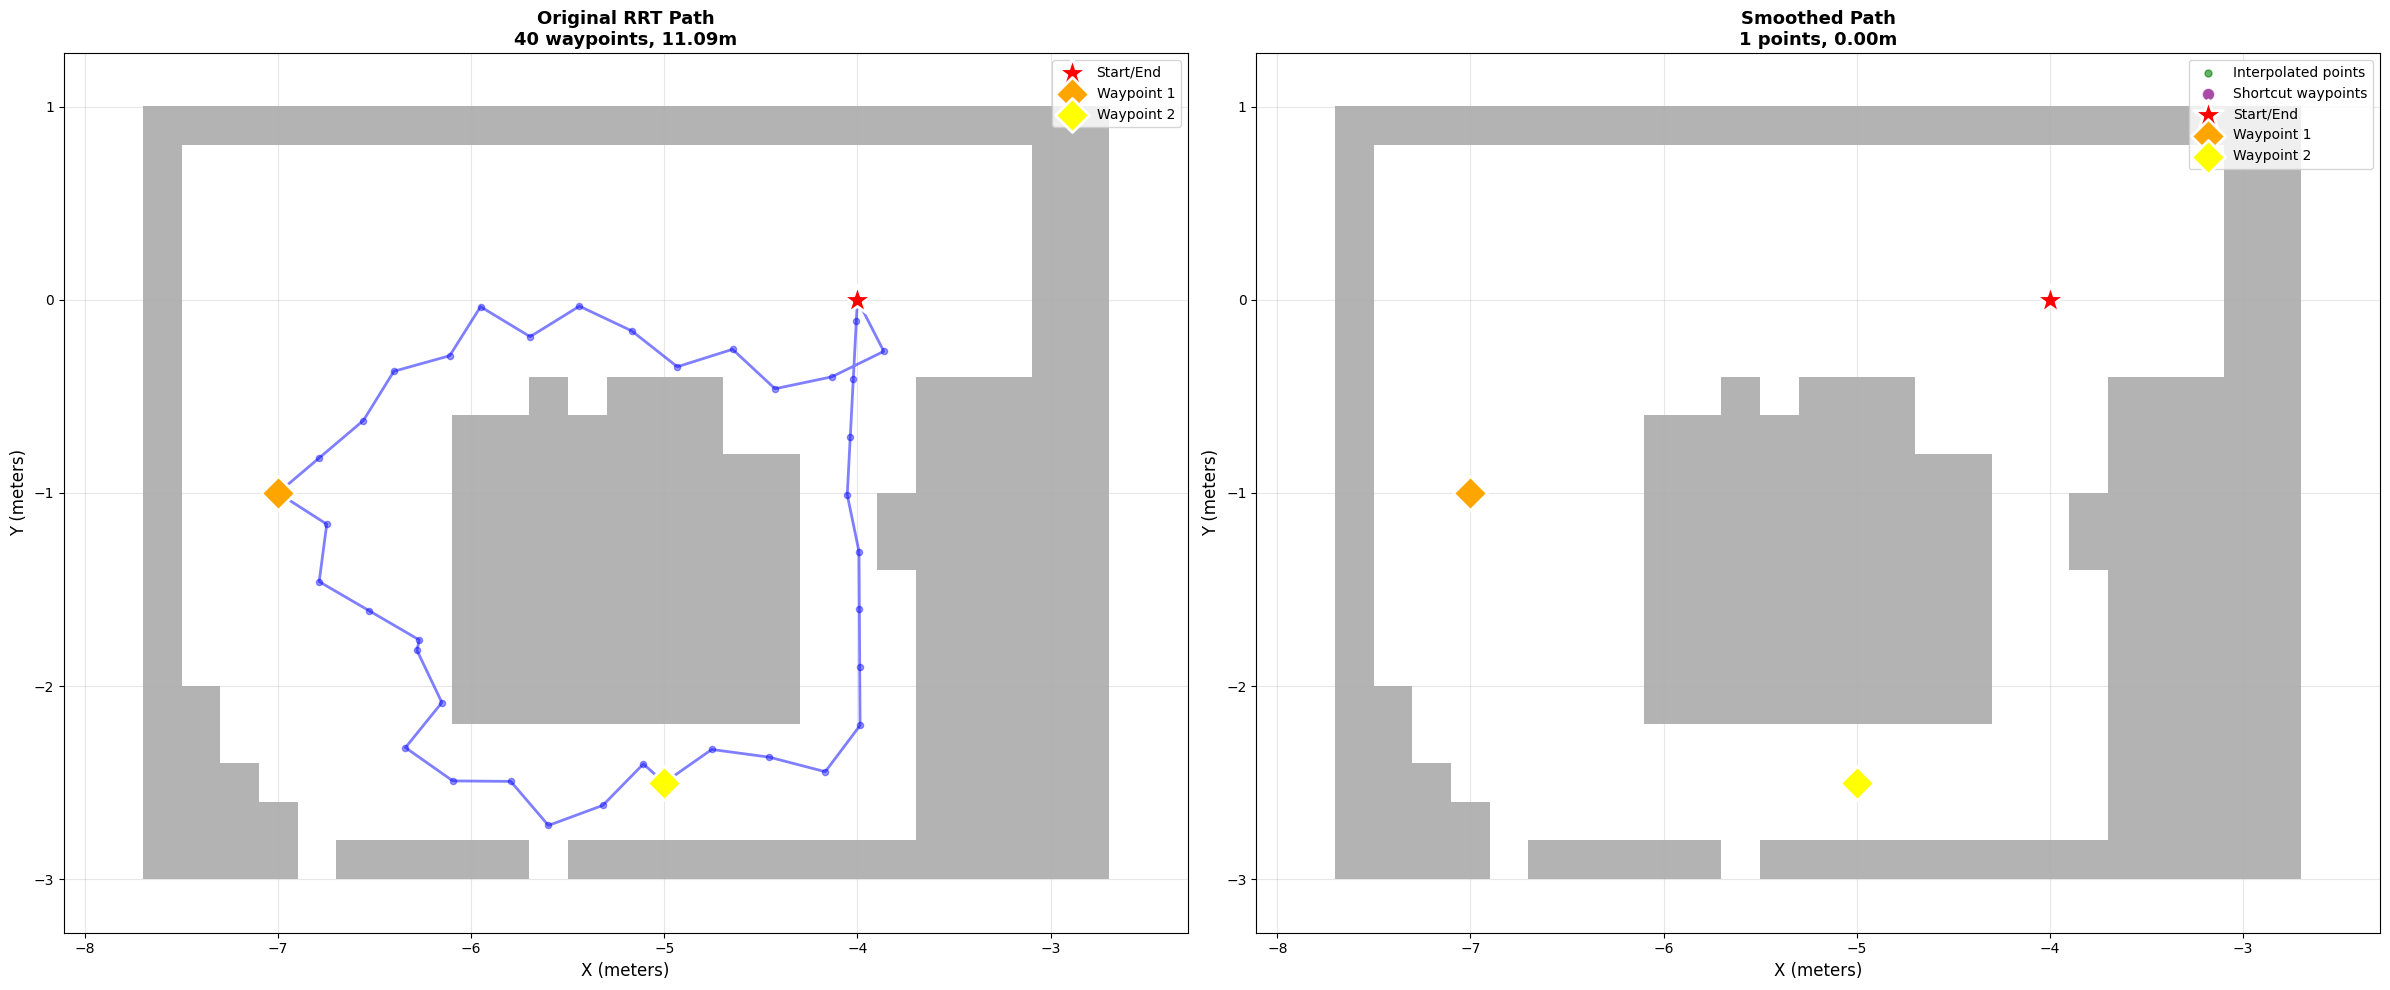

✓ Path comparison visualization complete


In [53]:
if path_segment_1 is not None and path_segment_2 is not None and path_segment_3 is not None:
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    # Left plot: Original RRT path
    ax = axes[0]
    ax.imshow(occupancy_grid, cmap='gray_r', origin='lower', 
              extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max], 
              alpha=0.3, interpolation='nearest')
    
    rrt_array = np.array(complete_rrt_path)
    ax.plot(rrt_array[:, 0], rrt_array[:, 1], 'b-', linewidth=2, alpha=0.5)
    ax.scatter(rrt_array[:, 0], rrt_array[:, 1], c='blue', s=20, alpha=0.4, zorder=5)
    
    ax.scatter(START_X, START_Y, c='red', s=500, marker='*', 
               edgecolors='white', linewidths=2, label='Start/End', zorder=10)
    ax.scatter(WAYPOINT_1[0], WAYPOINT_1[1], c='orange', s=300, marker='D', 
               edgecolors='white', linewidths=2, label='Waypoint 1', zorder=10)
    ax.scatter(WAYPOINT_2[0], WAYPOINT_2[1], c='yellow', s=300, marker='D', 
               edgecolors='white', linewidths=2, label='Waypoint 2', zorder=10)
    
    ax.set_xlim(grid_x_min, grid_x_max)
    ax.set_ylim(grid_y_min, grid_y_max)
    ax.set_xlabel('X (meters)', fontsize=12)
    ax.set_ylabel('Y (meters)', fontsize=12)
    ax.set_title(f'Original RRT Path\n{len(complete_rrt_path)} waypoints, {total_distance:.2f}m', 
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    # Right plot: Smoothed path
    ax = axes[1]
    ax.imshow(occupancy_grid, cmap='gray_r', origin='lower', 
              extent=[grid_x_min, grid_x_max, grid_y_min, grid_y_max], 
              alpha=0.3, interpolation='nearest')
    
    smooth_array = np.array(smooth_path)
    ax.plot(smooth_array[:, 0], smooth_array[:, 1], 'g-', linewidth=2.5, alpha=0.8)
    ax.scatter(smooth_array[::10, 0], smooth_array[::10, 1], c='green', s=25, 
               alpha=0.6, zorder=5, label='Interpolated points')
    
    # Show shortcut waypoints
    shortcut_array = np.array(shortcut_path_result)
    ax.scatter(shortcut_array[:, 0], shortcut_array[:, 1], c='purple', s=80, 
               alpha=0.7, marker='o', edgecolors='white', linewidths=1, 
               zorder=8, label='Shortcut waypoints')
    
    ax.scatter(START_X, START_Y, c='red', s=500, marker='*', 
               edgecolors='white', linewidths=2, label='Start/End', zorder=10)
    ax.scatter(WAYPOINT_1[0], WAYPOINT_1[1], c='orange', s=300, marker='D', 
               edgecolors='white', linewidths=2, label='Waypoint 1', zorder=10)
    ax.scatter(WAYPOINT_2[0], WAYPOINT_2[1], c='yellow', s=300, marker='D', 
               edgecolors='white', linewidths=2, label='Waypoint 2', zorder=10)
    
    ax.set_xlim(grid_x_min, grid_x_max)
    ax.set_ylim(grid_y_min, grid_y_max)
    ax.set_xlabel('X (meters)', fontsize=12)
    ax.set_ylabel('Y (meters)', fontsize=12)
    ax.set_title(f'Smoothed Path\n{len(smooth_path)} points, {smooth_distance:.2f}m', 
                 fontsize=13, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Path comparison visualization complete")
else:
    print("Cannot visualize - path planning failed")

## Generate Drake Trajectory and Simulate

Create a smooth Drake trajectory using the smoothed path and simulate in Meshcat.

In [58]:
if path_segment_1 is not None and path_segment_2 is not None and path_segment_3 is not None:
    import time
    
    print("="*60)
    print("Generating Drake trajectory from smoothed path...")
    print("="*60)
    
    # Check if we have enough waypoints for a proper trajectory
    # We need at least 3 waypoints to execute the three-segment path
    if len(smooth_path) < 10:
        print(f"⚠ Warning: smooth_path has only {len(smooth_path)} point(s)")
        print("Not enough points for three-segment path.")
        print("Using shortcut path instead...")
        trajectory_path = shortcut_path_result
    else:
        trajectory_path = smooth_path
    
    # Ensure we have enough waypoints for Drake trajectory
    if len(trajectory_path) < 10:
        print(f"⚠ Warning: trajectory_path has only {len(trajectory_path)} point(s)")
        print("Using complete RRT path for better coverage...")
        trajectory_path = complete_rrt_path
    
    # Final safety check
    if len(trajectory_path) < 2:
        print("⚠ ERROR: Not enough waypoints for trajectory generation!")
        print(f"Need at least 2 points, have {len(trajectory_path)}")
        print("Cannot proceed with simulation.")
    else:
        # Extract positions for trajectory
        path_array = np.array(trajectory_path)
        num_waypoints = len(trajectory_path)
        
        print(f"Using trajectory with {num_waypoints} waypoints")
        
        # Create time vector (velocity ~0.4 m/s for smooth motion)
        min_dt = 0.1  # minimum time between waypoints
        velocity = 0.4  # m/s
        
        times = [0.0]
        for i in range(1, num_waypoints):
            dist = np.linalg.norm(path_array[i] - path_array[i-1])
            dt = max(dist / velocity, min_dt)
            times.append(times[-1] + dt)
        
        times = np.array(times)
        
        # Calculate actual path distance
        actual_distance = 0
        for i in range(len(trajectory_path) - 1):
            p1 = np.array(trajectory_path[i])
            p2 = np.array(trajectory_path[i+1])
            actual_distance += np.linalg.norm(p2 - p1)
        
        print(f"Total trajectory time: {times[-1]:.2f} seconds")
        print(f"Path distance: {actual_distance:.2f} meters")
        print(f"Average velocity: {actual_distance / times[-1]:.2f} m/s")
        
        # Prepare trajectory knots for all mobile base joints
        mobile_iiwa = plant.GetModelInstanceByName("mobile_iiwa")
        num_positions = plant.num_positions(mobile_iiwa)
        
        knots = np.zeros((num_positions, num_waypoints))
        
        # Get joint indices
        base_x_joint = plant.GetJointByName("iiwa_base_x", mobile_iiwa)
        base_y_joint = plant.GetJointByName("iiwa_base_y", mobile_iiwa)
        base_z_joint = plant.GetJointByName("iiwa_base_z", mobile_iiwa)
        
        base_x_idx = base_x_joint.position_start()
        base_y_idx = base_y_joint.position_start()
        base_z_idx = base_z_joint.position_start()
        
        # Fill in base positions from trajectory path
        for i, (x, y) in enumerate(trajectory_path):
            knots[base_x_idx, i] = x
            knots[base_y_idx, i] = y
            knots[base_z_idx, i] = CHECK_HEIGHT
        
        # Create cubic trajectory
        trajectory = PiecewisePolynomial.CubicShapePreserving(
            times, knots, zero_end_point_derivatives=True
        )
        
        print(f"✓ Created cubic trajectory")
        print(f"  Dimensions: {trajectory.rows()} (mobile_iiwa has {num_positions} positions)")
        
        # Simulate with the trajectory
        print("\n" + "="*60)
        print("Running simulation...")
        print("="*60)
        
        # Create simulator
        simulator = Simulator(station)
        simulator_context = simulator.get_mutable_context()
        
        # Set initial conditions
        plant_context = plant.GetMyContextFromRoot(simulator_context)
        plant.SetPositions(plant_context, mobile_iiwa, knots[:, 0])
        
        # Start recording
        meshcat.StartRecording()
        print("Recording started...")
        
        # Publish initial state
        station.ForcedPublish(simulator_context)
        time.sleep(1)
        
        # Simulate
        print(f"Simulating for {times[-1]:.2f} seconds...")
        sample_rate = 30  # Hz
        dt = 1.0 / sample_rate
        current_time = 0.0
        
        step_count = 0
        while current_time <= times[-1]:
            # Evaluate trajectory
            desired_position = trajectory.value(current_time).flatten()
            
            # Set positions
            plant.SetPositions(plant_context, mobile_iiwa, desired_position)
            
            # Update visualization
            simulator_context.SetTime(current_time)
            station.ForcedPublish(simulator_context)
            
            # Print progress every 2 seconds
            if step_count % 60 == 0:
                x, y = desired_position[base_x_idx], desired_position[base_y_idx]
                progress = (current_time / times[-1]) * 100
                print(f"  t={current_time:.1f}s ({progress:.0f}%): position=({x:.2f}, {y:.2f})")
            
            # Advance time
            current_time += dt
            step_count += 1
            time.sleep(dt * 0.5)  # Half real-time for better visibility
        
        # Final state
        final_pos = trajectory.value(times[-1]).flatten()
        print(f"\n✓ Simulation complete!")
        print(f"Final position: ({final_pos[base_x_idx]:.2f}, {final_pos[base_y_idx]:.2f})")
        
        # Distance from start
        final_dist = np.sqrt((final_pos[base_x_idx] - START_X)**2 + 
                             (final_pos[base_y_idx] - START_Y)**2)
        print(f"Distance from start: {final_dist:.3f} meters")
        
        # Stop and publish recording
        meshcat.StopRecording()
        meshcat.PublishRecording()
        
        print("\n" + "="*60)
        print("✓ Animation recorded and published!")
        print("="*60)
        print("Use the Meshcat controls to replay the animation")
        print(f"Total animation time: {times[-1]:.1f} seconds")
else:
    print("Cannot simulate - path planning failed")

Generating Drake trajectory from smoothed path...
⚠ Warning: smooth_path has only 1 point(s)
Not enough points for three-segment path.
Using shortcut path instead...
⚠ Warning: trajectory_path has only 2 point(s)
Using complete RRT path for better coverage...
Using trajectory with 40 waypoints
Total trajectory time: 27.73 seconds
Path distance: 11.09 meters
Average velocity: 0.40 m/s
✓ Created cubic trajectory
  Dimensions: 10 (mobile_iiwa has 10 positions)

Running simulation...
Recording started...
Simulating for 27.73 seconds...
  t=0.0s (0%): position=(-4.00, 0.00)
Simulating for 27.73 seconds...
  t=0.0s (0%): position=(-4.00, 0.00)
  t=2.0s (7%): position=(-4.33, -0.45)
  t=2.0s (7%): position=(-4.33, -0.45)
  t=4.0s (14%): position=(-5.01, -0.31)
  t=4.0s (14%): position=(-5.01, -0.31)
  t=6.0s (22%): position=(-5.69, -0.19)
  t=6.0s (22%): position=(-5.69, -0.19)
  t=8.0s (29%): position=(-6.31, -0.34)
  t=8.0s (29%): position=(-6.31, -0.34)
  t=10.0s (36%): position=(-6.88, -0

In [55]:
# Replay the animation - this will restart the recorded animation in Meshcat
meshcat.PublishRecording()
print("Animation replayed! Check the Meshcat viewer.")
print("You can control playback speed and position using the recording controls.")

Animation replayed! Check the Meshcat viewer.
You can control playback speed and position using the recording controls.


## Replay Animation

Replay the recorded animation at any time.